Let's look at the catalogs generated by the corrected vs. uncorrected diffims...

In [2]:
import numpy as np
import pandas as pd

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

In [2]:
import lsst.daf.persistence as dp
if False:
    butler=dp.Butler('decamDirTest')
    sources=butler.get('deepDiff_diaSrc',visit=289820,ccdnum=11)
    #print sources[0].extract('ip_diffim_Naive*')

if False:
# df1 will be the corrected one.
    df1 = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
    #df1.head()

if False:
# df2 will be the corrected one.
    df2 = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
    #df2.head()

# Now let's save them out...
if False:
    import cPickle
    import gzip
    cPickle.dump((df1, df2), gzip.GzipFile('twoCatalogs.p.gz', 'wb'))

In [1]:
import cPickle
import gzip

df1, df2 = cPickle.load(gzip.GzipFile('twoCatalogs.p.gz', 'rb'))
print df1.shape, df2.shape
#print df1.columns.values

(47, 133) (143, 133)


143 143


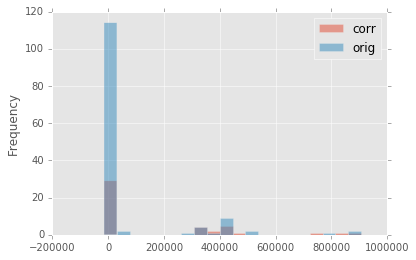

In [10]:
#print df1.columns.values
fluxes1 = df1.base_CircularApertureFlux_50_0_flux
fluxes2 = df2.base_CircularApertureFlux_50_0_flux
fluxes1 = np.append(fluxes1, np.repeat(np.nan, len(fluxes2)-len(fluxes1)))
print len(fluxes2),len(fluxes1)
df = pd.DataFrame({'corr': fluxes1, 'orig': fluxes2})
df.plot.hist(alpha=0.5, bins=20)

Find matches between the two catalogs in RA and Dec.

In [19]:
dist = np.sqrt(np.add.outer(df1.coord_dec, -df2.coord_dec)**2. + \
               np.add.outer(df1.coord_ra, -df2.coord_ra)**2.) * 206264.806247  # convert to arcsec ?
print dist.min(), np.unravel_index(np.argmin(dist), dist.shape), dist[18,48]
print df1.iloc[18].coord_dec, df1.iloc[18].coord_ra, '\t', df2.iloc[48].coord_dec, df2.iloc[48].coord_ra
print np.sum(dist < 4.)
matches = np.where(dist < 4.)
#print matches
print dist[0,0], df1.iloc[0].coord_dec, df1.iloc[0].coord_ra, '\t', df2.iloc[0].coord_dec, df2.iloc[0].coord_ra

matches1 = df1.iloc[matches[0]]
matches2 = df2.iloc[matches[1]]

fluxes1 = matches1.base_CircularApertureFlux_50_0_flux.values
fluxes2 = matches2.base_CircularApertureFlux_50_0_flux.values

fluxSigs1 = matches1.base_CircularApertureFlux_50_0_fluxSigma.values
fluxSigs2 = matches2.base_CircularApertureFlux_50_0_fluxSigma.values

isgood = ~np.isnan(fluxes1) & ~np.isnan(fluxes2)
isgood2 = ~np.isnan(fluxes1) & ~np.isnan(fluxes2) & ~np.isnan(fluxSigs1) & ~np.isnan(fluxSigs2)

fluxes1 = fluxes1[isgood]
fluxes2 = fluxes2[isgood]
fluxSigs1 = np.sqrt(fluxSigs1[isgood2])
fluxSigs2 = np.sqrt(fluxSigs2[isgood2])

0.00174137799121 (18, 48) 0.00174137799121
-0.104489022363 2.71678934598 	-0.104489013982 2.71678934699
45
0.0063943728011 -0.104245305196 2.71568871571 	-0.104245278038 2.71568870076


[   0.95530517  633.50516061] [  1.81661127e-03   5.27274024e+02]
0.958343834091
[  1.16808636  17.44637564] [  1.64530721e-03   1.06930292e+01]
1.44415737351


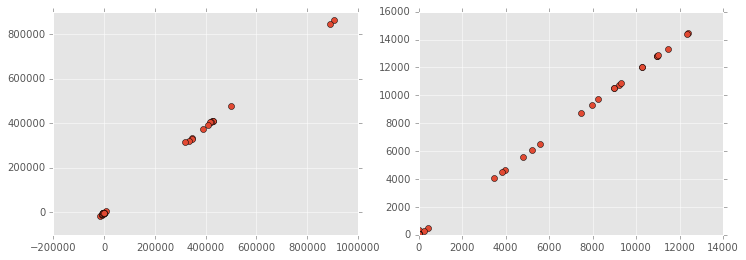

In [20]:
pars, cov = np.polyfit(fluxes2, fluxes1, deg=1, cov=True)
print pars, np.sqrt(np.diag(cov))
#print pearsonr(fluxes2, fluxes1)
print np.mean(fluxes1/fluxes2)

pars, cov = np.polyfit(fluxSigs2, fluxSigs1, deg=1, cov=True)
print pars, np.sqrt(np.diag(cov))
#print pearsonr(fluxSigs2, fluxSigs1)
print np.mean(fluxSigs1/fluxSigs2)

plt.figure(1, (12,4))
plt.subplot(121)
plt.plot(fluxes2, fluxes1, 'o')
plt.subplot(122)
plt.plot(fluxSigs2, fluxSigs1, 'o')

In [6]:
df1.columns.values

array(['base_CircularApertureFlux_12_0_flag',
       'base_CircularApertureFlux_12_0_flag_apertureTruncated',
       'base_CircularApertureFlux_12_0_flux',
       'base_CircularApertureFlux_12_0_fluxSigma',
       'base_CircularApertureFlux_17_0_flag',
       'base_CircularApertureFlux_17_0_flag_apertureTruncated',
       'base_CircularApertureFlux_17_0_flux',
       'base_CircularApertureFlux_17_0_fluxSigma',
       'base_CircularApertureFlux_25_0_flag',
       'base_CircularApertureFlux_25_0_flag_apertureTruncated',
       'base_CircularApertureFlux_25_0_flux',
       'base_CircularApertureFlux_25_0_fluxSigma',
       'base_CircularApertureFlux_35_0_flag',
       'base_CircularApertureFlux_35_0_flag_apertureTruncated',
       'base_CircularApertureFlux_35_0_flux',
       'base_CircularApertureFlux_35_0_fluxSigma',
       'base_CircularApertureFlux_3_0_flag',
       'base_CircularApertureFlux_3_0_flag_apertureTruncated',
       'base_CircularApertureFlux_3_0_flag_sincCoeffsTruncated',

In [7]:
print np.mean(df1.ip_diffim_DipoleFit_flag_classification.values)
print np.mean(df2.ip_diffim_DipoleFit_flag_classification.values)
print np.mean(matches1.ip_diffim_DipoleFit_flag_classification.values)
print np.mean(matches2.ip_diffim_DipoleFit_flag_classification.values)
print;
print np.mean(df1.ip_diffim_ClassificationDipole_value)
print np.mean(df2.ip_diffim_ClassificationDipole_value)
print np.mean(matches1.ip_diffim_ClassificationDipole_value)
print np.mean(matches2.ip_diffim_ClassificationDipole_value)

0.893617021277
0.832167832168
0.933333333333
0.866666666667

0.148936170213
0.0559440559441
0.155555555556
0.155555555556


Let's try to make the plot in Colin's DMTN-006 -- first run his script

```
python forcePhotDiaSources.py decamDirTest --output decamDirTest/ --id visit=289820 ccdnum=11 --templateId visit=288976 --no-versions
```

then...

In [3]:
import lsst.daf.persistence as dp
butler=dp.Butler('decamDirTest')
sources=butler.get('forced_src',visit=289820,ccdnum=11)
df = pd.DataFrame({col: sources.columns[col] for col in sources.schema.getNames()})
df.head()

,base_PsfFlux_flag,base_PsfFlux_flag_edge,base_PsfFlux_flag_noGoodPixels,base_PsfFlux_flux,base_PsfFlux_fluxSigma,base_TransformedCentroid_flag,base_TransformedCentroid_x,base_TransformedCentroid_y,classification_dipole,coord_dec,coord_ra,diffim_base_PsfFlux_flux,diffim_base_PsfFlux_fluxSigma,objectId,parentObjectId,template_base_PsfFlux_flux,template_base_PsfFlux_fluxSigma
0,False,False,False,-246.099888,1.817813e+06,False,1193.792603,20.807241,0,-0.103987,2.715668,NaN,NaN,124476789417312674,0,69.835313,49.963969
1,False,False,False,-216.628938,6.196168e+01,False,870.371216,29.790710,0,-0.103575,2.715679,-353.513617,63.804781,124476789417312675,0,106.350249,49.813518
2,False,False,False,11371.922845,8.896379e+01,False,1397.263306,36.963974,0,-0.104245,2.715689,-764.966500,92.162893,124476789417312676,0,12919.007157,82.709406
3,False,False,False,-271.012925,6.199320e+01,False,232.097687,48.177261,0,-0.102764,2.715703,-380.106921,63.830763,124476789417312677,0,103.862668,50.967618
4,False,False,False,-159.819964,6.294722e+01,False,1972.474121,48.286854,0,-0.104977,2.715703,-352.040888,64.954801,124476789417312678,0,142.777126,49.489625


In [4]:
df[['base_PsfFlux_flux', 'template_base_PsfFlux_flux']].head()
df['s_to_n'] = df.base_PsfFlux_flux / df.base_PsfFlux_fluxSigma
df['template_s_to_n'] = df.template_base_PsfFlux_flux / df.template_base_PsfFlux_fluxSigma
print df.columns.values
df[['s_to_n', 'template_s_to_n']].head()

['base_PsfFlux_flag' 'base_PsfFlux_flag_edge'
 'base_PsfFlux_flag_noGoodPixels' 'base_PsfFlux_flux'
 'base_PsfFlux_fluxSigma' 'base_TransformedCentroid_flag'
 'base_TransformedCentroid_x' 'base_TransformedCentroid_y'
 'classification_dipole' 'coord_dec' 'coord_ra' 'diffim_base_PsfFlux_flux'
 'diffim_base_PsfFlux_fluxSigma' 'objectId' 'parentObjectId'
 'template_base_PsfFlux_flux' 'template_base_PsfFlux_fluxSigma' 's_to_n'
 'template_s_to_n']


,s_to_n,template_s_to_n
0,-0.000135,1.397713
1,-3.496176,2.134968
2,127.826420,156.197557
3,-4.371655,2.037817
4,-2.538952,2.884991


7.0710678118654755

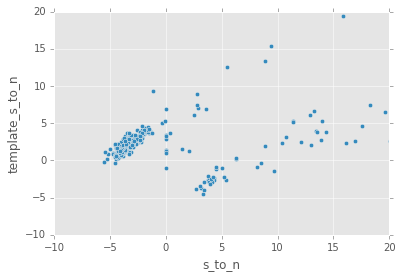

In [5]:
df.plot.scatter('s_to_n', 'template_s_to_n')
plt.xlim(-10, 20)
plt.ylim(-10, 20)
5. * np.sqrt(2.)